In [8]:
import pandas as pd
from sqlalchemy import create_engine
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.corpus import wordnet

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from jupyterthemes import jtplot
import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import seaborn as sns

import data_utils_mt.utils as utils

In [2]:
# load data from database
DB_NAME = '../data/DisasterResponse.db'
MESSAGES_TABLE = 'messages'

engine = create_engine('sqlite:///{}'.format(DB_NAME))
df = pd.read_sql_table(MESSAGES_TABLE, engine)
print(df.shape)
df.head()

(26216, 40)


,id,message,original,genre,aid_centers,aid_related,buildings,child_alone,clothing,cold,...,request,search_and_rescue,security,shelter,shops,storm,tools,transport,water,weather_related
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
positive = df.iloc[:, 4:].sum()
negative = df.shape[0] - positive

positive = positive.sort_values(ascending=True)
negative = negative.sort_values(ascending=True)

In [4]:
positive.index.tolist()

['child_alone',
 'offer',
 'shops',
 'tools',
 'fire',
 'hospitals',
 'missing_people',
 'aid_centers',
 'clothing',
 'security',
 'cold',
 'electricity',
 'money',
 'search_and_rescue',
 'military',
 'refugees',
 'other_infrastructure',
 'death',
 'transport',
 'medical_products',
 'buildings',
 'other_weather',
 'water',
 'infrastructure_related',
 'medical_help',
 'floods',
 'shelter',
 'storm',
 'earthquake',
 'food',
 'other_aid',
 'request',
 'direct_report',
 'weather_related',
 'aid_related',
 'related']

In [49]:
positive.shape

(36,)

In [5]:
trace1 = go.Bar(
    y=positive.index.tolist(),
    x=positive.values.tolist(),
    name='Positive label',
    orientation='h'
)
trace2 = go.Bar(
    y=negative.index.tolist(),
    x=negative.values.tolist(),
    name='Negative label',
    orientation='h'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

In [6]:
trace1 = go.Bar(
    x=positive.index.tolist(),
    y=positive.values.tolist(),
    name='Positive label',
)
trace2 = go.Bar(
    x=negative.index.tolist(),
    y=negative.values.tolist(),
    name='Negative label',
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

In [9]:
clustered_labels, cluster_idx = utils.cluster_corr(df.iloc[:, 4:])

/Users/antelinvestigacionydesarrollo/anaconda3/envs/data/lib/python3.6/site-packages/data_utils_mt/utils.py:80: FutureWarning:

'.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.



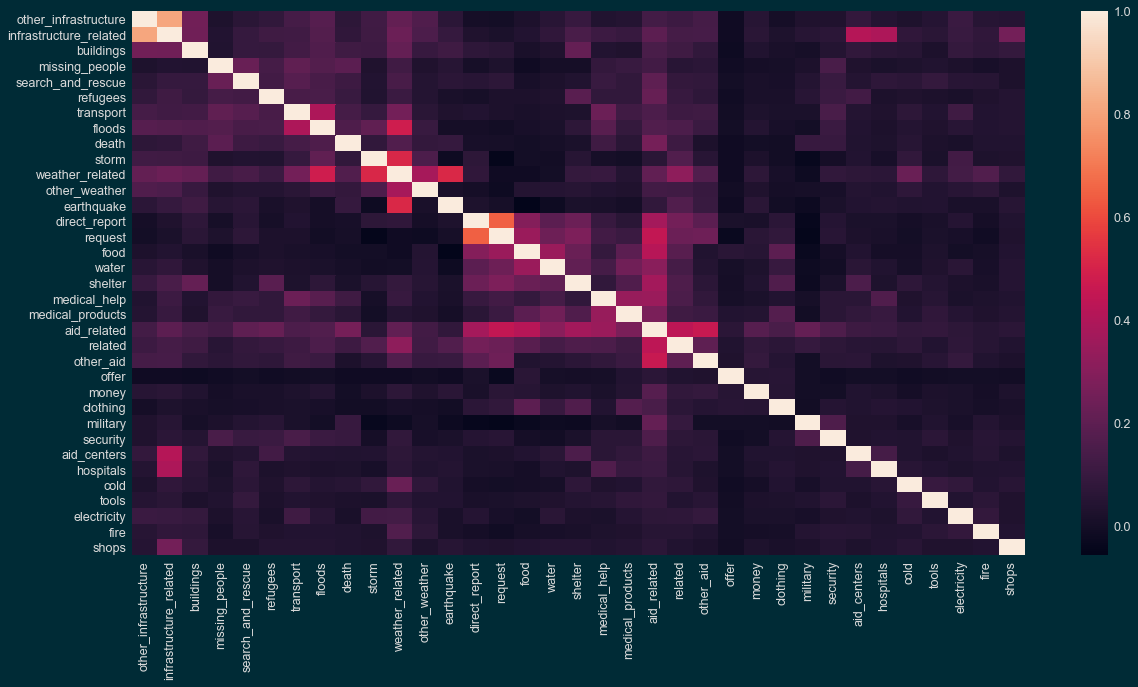

In [10]:
sns.heatmap(clustered_labels.corr().dropna(
    how='all', axis=0).dropna(how='all', axis=1))

In [16]:
correlations = clustered_labels.corr().dropna(
    how='all', axis=0).dropna(how='all', axis=1)

In [18]:
trace = go.Heatmap(
    x=correlations.index.values,
    y=correlations.index.values,
    z=correlations.values
)
data=[trace]
iplot(data)

In [19]:
from models.model import Model

In [21]:
model = Model()

In [22]:
from tqdm import tqdm

In [27]:
tokenized = list()
for text in tqdm(df.message):
    tokenized.append(model.tokenize(text))

100%|██████████| 26216/26216 [01:25<00:00, 306.93it/s]


In [50]:
%time tokenized = [model.tokenize(text) for text in df.message]

CPU times: user 1min 1s, sys: 3.73 s, total: 1min 5s
Wall time: 1min 7s


In [29]:
import numpy as np

In [30]:
tokenized_arr = np.concatenate(tokenized)
tokenized_arr[:20]

array(['weather', 'updat', 'cold', 'front', 'cuba', 'could', 'pass',
       'haiti', 'hurrican', 'look', 'someon', 'name', 'un', 'report',
       'leogan', '80', '90', 'destroy', 'hospit', 'st'], dtype='<U160')

In [31]:
tokenized_arr.shape

(381984,)

In [32]:
values, counts = np.unique(tokenized_arr, return_counts=True)

In [44]:
counts_df = pd.Series(counts, index=values)
counts_df = counts_df.sort_values(ascending=False)
counts_df.head()

water    3046
peopl    3017
food     2904
help     2857
need     2755
dtype: int64

In [47]:
counts_to_plot = counts_df.iloc[:20].sort_values(ascending=True)
counts_to_plot

govern       1116
thank        1175
find         1183
know         1211
countri      1250
000          1254
http         1258
flood        1439
would        1491
like         1635
area         1667
u            1757
say          1852
earthquak    1923
pleas        2060
need         2755
help         2857
food         2904
peopl        3017
water        3046
dtype: int64

In [48]:
trace1 = go.Bar(
    y=counts_to_plot.index.tolist(),
    x=counts_to_plot.values.tolist(),
    name='Most frequent tokens',
    orientation='h'
)

data = [trace1]
layout = go.Layout(
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)